In [1]:
from momentfm import MOMENTPipeline

model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large", 
    model_kwargs={"task_name": "reconstruction"},
)
model.init()

d:\Projects\MOMENT_Test\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Projects\MOMENT_Test\.venv\Lib\site-packages\transformers\utils\generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
from momentfm.utils.utils import control_randomness
control_randomness(seed=13) # Set random seeds for PyTorch, Numpy etc.

In [3]:
print(model)

MOMENTPipeline(
  (normalizer): RevIN()
  (tokenizer): Patching()
  (patch_embedding): PatchEmbedding(
    (value_embedding): Linear(in_features=8, out_features=1024, bias=False)
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
  

In [4]:
# Number of parameters in the encoder
num_params = sum(p.numel() for p in model.encoder.parameters())
print(f"Number of parameters: {num_params}")

Number of parameters: 341231104


In [5]:
from pprint import pprint
import torch

# takes in tensor of shape [batch_size, n_channels, context_length]
x = torch.randn(16, 1, 512)
output = model(x_enc=x)
pprint(output)

d:\Projects\MOMENT_Test\.venv\Lib\site-packages\torch\_dynamo\eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
d:\Projects\MOMENT_Test\.venv\Lib\site-packages\torch\utils\checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


TimeseriesOutputs(forecast=None,
                  anomaly_scores=None,
                  logits=None,
                  labels=None,
                  input_mask=tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]]),
                  pretrain_mask=tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]]),
                  reconstruction=tensor([[[ 0.0859, -0.0572, -0.0356,  ..., -0.0572, -0.0935, -0.2595]],

        [[-0.4189, -0.1158, -0.1405,  ...,  0.2558, -0.1384,  0.0088]],

        [[ 0.1040, -0.0625,  0.2719,  ...,  0.0315, -0.0361, -0.1430]],

        ...,

        [[ 0.1575,  0.0724,  0.0724,  ..., -0.0249,  0.0053, -0.0

In [6]:
from momentfm.data.informer_dataset import InformerDataset
from torch.utils.data import DataLoader

test_dataset = InformerDataset(
    data_split='test', 
    task_name='imputation', 
    data_stride_len=512)

test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [7]:
from momentfm.utils.masking import Masking

mask_generator = Masking(mask_ratio=0.25) # Mask 25% of patches randomly 

In [8]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda:0


In [9]:
from tqdm import tqdm
import numpy as np

device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = model.to(device).float()

trues, preds, masks = [], [], []
with torch.no_grad():
    for batch_x, batch_masks in tqdm(test_dataloader, total=len(test_dataloader)):
        trues.append(batch_x.numpy())
        
        batch_x = batch_x.to(device).float()
        n_channels = batch_x.shape[1]
        
        # Reshape to [batch_size * n_channels, 1, window_size]
        batch_x = batch_x.reshape((-1, 1, 512)) 
        
        batch_masks = batch_masks.to(device).long()
        batch_masks = batch_masks.repeat_interleave(n_channels, axis=0)
        
        mask = mask_generator.generate_mask(
            x=batch_x, input_mask=batch_masks).to(device).long()

        output = model(x_enc=batch_x, input_mask=batch_masks, mask=mask) # [batch_size, n_channels, window_size]
        
        reconstruction = output.reconstruction.detach().cpu().numpy()
        mask = mask.detach().squeeze().cpu().numpy()
        
        # Reshape back to [batch_size, n_channels, window_size]
        reconstruction = reconstruction.reshape((-1, n_channels, 512)) 
        mask = mask.reshape((-1, n_channels, 512))
                
        preds.append(reconstruction)
        masks.append(mask)

preds = np.concatenate(preds)
trues = np.concatenate(trues)
masks = np.concatenate(masks)

print(f"Shapes: preds={preds.shape} | trues={trues.shape} | masks={masks.shape}")

  0%|          | 0/1 [00:00<?, ?it/s]d:\Projects\MOMENT_Test\.venv\Lib\site-packages\torch\_dynamo\eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
d:\Projects\MOMENT_Test\.venv\Lib\site-packages\torch\utils\checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

Shapes: preds=(6, 7, 512) | trues=(6, 7, 512) | masks=(6, 7, 512)


In [10]:
from momentfm.utils.forecasting_metrics import mse, mae

print(f"Mean Squarred Error (MSE)={mse(y=trues[masks==0], y_hat=preds[masks==0], reduction='mean')}")
print(f"Mean Absolute Error (MAE)={mae(y=trues[masks==0], y_hat=preds[masks==0], reduction='mean')}")

Mean Squarred Error (MSE)=0.4276402346453534
Mean Absolute Error (MAE)=0.4084315280454546


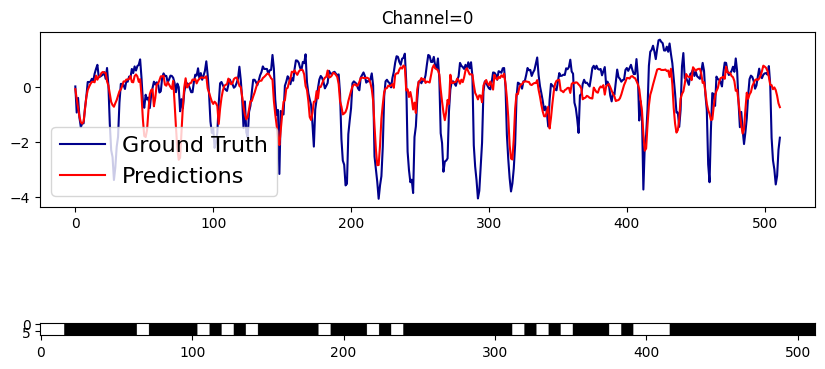

In [12]:
from matplotlib import pyplot as plt
idx = np.random.randint(trues.shape[0])
channel_idx = np.random.randint(trues.shape[1])

fig, axs = plt.subplots(2, 1, figsize=(10, 5))
axs[0].set_title(f"Channel={channel_idx}")
axs[0].plot(trues[idx, channel_idx, :].squeeze(), label='Ground Truth', c='darkblue')
axs[0].plot(preds[idx, channel_idx, :].squeeze(), label='Predictions', c='red')
axs[0].legend(fontsize=16)

axs[1].imshow(np.tile(masks[np.newaxis, idx, channel_idx], reps=(8, 1)), cmap='binary')
plt.show()